In [157]:
# Libraries
import torch
import matplotlib.pyplot as plt
%matplotlib inline
import torch.nn as nn
import numpy as np
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.tree import DecisionTreeClassifier
import random
import numpy as np

# Standard approach (de-identified experts)

In [2]:
class Linear_net_rej(nn.Module):
    '''
   (Mozannar & Sontag) Linear classifier and deferral for L_CE loss for binary response
   novel convex consistent surrogate loss
    '''
    def __init__(self, input_dim, out_dim):
        super(Linear_net_rej, self).__init__()
        # an affine operation: y = Wx + b
        self.fc = nn.Linear(input_dim, out_dim+1) # out: 0,1,2
        self.fc_rej = nn.Linear(input_dim, 1)
        torch.nn.init.ones_(self.fc.weight)
        torch.nn.init.ones_(self.fc_rej.weight)
        self.softmax = nn.Softmax(dim=0) # dim = 0 to get 0,1,2 as output

    def forward(self, x):
        out = self.fc(x)
        rej = self.fc_rej(x)
        #out = torch.cat([out,rej],1)
        out = self.softmax(out)
        return out

In [3]:
def reject_CrossEntropyLoss(outputs, h, labels, m, n_classes):
    '''
    (Mozannar & Sontag) Implmentation of L_{CE}^{\alpha}
        outputs: classifier and rejector model outputs
        h: cost of deferring to expert cost of classifier predicting (I_{m =y})
        labels: target
        m: cost of classifier predicting (alpha* I_{m\neq y} + I_{m =y})
        n_classes: number of classes/outputs
    '''    
    batch_size = outputs.size()[0]            # batch_size
    rc = torch.tensor([n_classes] * batch_size, dtype=torch.long)
    #labels = torch.tensor(labels, dtype=torch.long)
    labels = labels.clone().detach().long()
    outputs =  -h*torch.log2( outputs[range(batch_size), rc]) - m*torch.log2(outputs[range(batch_size), labels])   # pick the values corresponding to the labels
    return torch.sum(outputs)/batch_size

In [4]:
def run_classifier_rej(model, exp_heuristic, data_x, data_y, alpha, p, k):
    '''
    (Mozannar & Sontag) training script for L_{CE}
        model: classifier and rejector model
        data_x: input
        data_y: label
        alpha: hyperparam alpha for loss L_CE^{\alpha}
        p: probability of randomly selecting expert 1
    '''
    
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, betas=(0.5, 0.99), weight_decay=1)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, len(data_x)*100)
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=3.0)

    for epoch in range(1):  # loop over the dataset multiple times
        inputs = torch.tensor(data_x)
        labels = torch.tensor(data_y)

        # split to create batch size
        x_batches = torch.split(inputs, 5)
        y_batches = torch.split(labels, 5) 

        loss_train = []

        model_predictions = 0
        expert_predictions = 0
        total_samples = 0


        for inputs, labels in zip(x_batches, y_batches):

            optimizer.zero_grad()

            # forward + backward + optimize
            rand_exp = random.choices([1, k], weights=[p, 1-p])[0] # randomly select expert k

            predicted = torch.tensor(exp_heuristic[rand_exp-1](inputs))  # get predictions from selected expert
            
            h = (predicted==labels)*1
            m = [0] * len(inputs) 
            for j in range (0,len(inputs)): # determines weights
                if h[j]:
                    m[j] = alpha
                    expert_predictions += 1
                else:
                    m[j] = 1

            h = h.clone().detach()
            m = torch.tensor(m)
            inputs = inputs.to(model.fc.weight.dtype)
            outputs = model(inputs)

            # Loss
            loss = reject_CrossEntropyLoss(outputs, h, labels, m, 2) # this is loss for classifier and rejector, 2 outputs
            loss.backward()
            optimizer.step()
            scheduler.step()
            loss_train.append(loss.item())


            # Training accuracy
            model_predictions += torch.sum((torch.argmax(outputs, dim=1) == labels).float()).item()
            expert_predictions += torch.sum((torch.argmax(predicted) == labels).float()).item()
            total_samples += len(labels)
            #model_accuracy = model_predictions / total_samples
            #expert_accuracy = expert_predictions / total_samples

    #print('Model Training Accuracy: ', model_accuracy)
    #print('Overall Expert Training Accuracy:', expert_accuracy)
'''
    plt.plot(loss_train, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss over Epochs')
    plt.legend()
    plt.show()
   '''     
            #print("loss " + str(loss.item()))

"\n    plt.plot(loss_train, label='Training Loss')\n    plt.xlabel('Epoch')\n    plt.ylabel('Loss')\n    plt.title('Training Loss over Epochs')\n    plt.legend()\n    plt.show()\n   "

In [5]:
def test_classifier_rej(model, exp_heuristic, data_x, data_y, p, k, exp_instances):
    '''
    (Mozannar & Sontag) Test classifier and deferral model for L_{CE} loss
    '''
    correct = 0
    correct_sys = 0
    exp = [0]*k
    exp_total = [0]*k
    total = 0
    real_total = 0
    points = len(data_x)

    with torch.no_grad():
        inputs = torch.tensor(data_x)
        labels = torch.tensor(data_y)

        inputs = inputs.to(model.fc.weight.dtype)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1) #0/1 (ML), 2 (defer to expert)
        predicted_exp = [torch.tensor(exp_heuristic(inputs)) for exp_heuristic in exp_heuristic]

        for i in range(len(inputs)):
            r = (predicted[i] == 2).item() # if 2, then defer to expert
            if r:
                rand_exp = random.choices([1, k], weights=[p, 1-p])[0] # randomly select expert for each point
                correct_sys += (predicted_exp[rand_exp-1][i] == labels[i]).item()
                exp[rand_exp-1] += (predicted_exp[rand_exp-1][i] == labels[i]).item()
                exp_total[rand_exp-1] += 1
                exp_instances[rand_exp-1].append(i)
            else: 
                correct += (predicted[i] == labels[i]).item()
                correct_sys += (predicted[i] == labels[i]).item()
                total += 1
        real_total += labels.size(0)

    print("system accuracy", 100 * correct_sys / real_total)
    print("total points:", points)
    print()

    for idx, (c, expert_total) in enumerate(zip(exp, exp_total)):
        print(f"Expert {idx+1} defer count:", expert_total)
        print(f"Expert {idx+1} defer percent:", 100 * expert_total / points if expert_total != 0 else 0)
        print(f"Expert {idx+1} correct predictions:", c)
        print(f"Expert {idx+1} accuracy:", 100 * c / (expert_total + 0.0002) if expert_total != 0 else 0)
        print()

    print("Not deferred to any expert count:", total)
    print("Not deferred percent:", 100 * total / points)
    print("Model correct predictions:", correct)
    print("Model accuracy:", 100 * correct / (total + 0.0001))
    print()

    #ratios = [exp_total / exp_correct if exp_correct != 0 else 0 for exp_total, exp_correct in zip(exp_total, exp)]
    #for idx, ratio in enumerate(ratios):
        #print(f"Expert {idx+1} to other experts ratio:", ratio)

    print()
    overall_exp_total = sum(exp_total)
    overall_exp_correct = sum(exp)
    print("Overall expert count:", overall_exp_total)
    print("Overall expert defer percent:", 100 * overall_exp_total / points)
    print("Overall expert correct predictions:", overall_exp_correct)
    print("Overall expert accuracy:", 100 * overall_exp_correct / (overall_exp_total + 0.0001) if overall_exp_total != 0 else 0)

    return exp_instances

# Optimal approach

In [6]:
class Linear_net_rej_id(nn.Module):
    '''
   (Mozannar & Sontag) Linear classifier and deferral for L_CE loss for binary response
   novel convex consistent surrogate loss
    '''
    def __init__(self, input_dim, out_dim, k):
        super(Linear_net_rej_id, self).__init__()
        # an affine operation: y = Wx + b
        self.fc = nn.Linear(input_dim, out_dim+k) # out: 0,1,2,3
        self.fc_rej = nn.Linear(input_dim, 1)
        torch.nn.init.ones_(self.fc.weight)
        torch.nn.init.ones_(self.fc_rej.weight)
        self.softmax = nn.Softmax(dim=0) # dim = 0 to get 0,1,2,3 as output

    def forward(self, x):
        out = self.fc(x)
        rej = self.fc_rej(x)
        #out = torch.cat([out,rej],1)
        out = self.softmax(out)
        return out

In [7]:
def reject_CrossEntropyLoss_id(outputs, h, labels, m, n_classes):
    '''
    (Mozannar & Sontag) Implmentation of L_{CE}^{\alpha}
        outputs: classifier and rejector model outputs
        h: cost of deferring to expert k cost of classifier predicting (I_{m =y})
        labels: target
        m: cost of classifier predicting (alpha* I_{m\neq y} + I_{m =y})
        n_classes: number of classes, binary here
    '''    
    batch_size = outputs.size()[0]            # batch_size
    rc = torch.tensor([n_classes] * batch_size, dtype=torch.long)
    labels = labels.clone().detach().long()
    outputs_exp = [torch.zeros(batch_size) for _ in range(k)]

    for i in range(k):
        outputs_exp[i] = -h[i] * torch.log2(outputs[range(batch_size), rc]) - m[:, i] * torch.log2(outputs[range(batch_size), labels])

    outputs = sum(outputs_exp)  # Sum the losses from all experts
    
    return torch.sum(outputs) / batch_size

In [8]:
def run_classifier_rej_id(model, exp_heuristic, data_x, data_y, alpha, k):
    '''
    (Mozannar & Sontag) training script for L_{CE}
        model: classifier and rejector model
        data_x: input
        data_y: label
        alpha: expert 1 hyperparam alpha for loss L_CE^{\alpha} 
        beta: expert 2 hyperparam alpha for loss L_CE^{\beta} 
        p: probability of randomly selecting expert 1
    '''
    
    optimizer = torch.optim.Adam(model.parameters(), lr=0.08, betas = (0.75, .1), weight_decay=.2)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, len(data_x)*100)
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=3.0)

    for epoch in range(1):  # loop over the dataset multiple times
        inputs = torch.tensor(data_x)
        labels = torch.tensor(data_y)

        # split to create batch size
        x_batches = torch.split(inputs, 5)
        y_batches = torch.split(labels, 5) 

        loss_train = []

        for inputs, labels in zip(x_batches, y_batches):

            optimizer.zero_grad()

            predicted = [torch.tensor(expert(inputs)) for expert in exp_heuristic]

            h_list = [(expert_output == labels) * 1 for expert_output in predicted]

            m = torch.zeros(len(inputs), k)

            for j in range(len(inputs)):
                for i in range(k):
                    if h_list[i][j]:
                        m[j][i] = alpha
                    else:
                        m[j][i] = 1

            h_list = [h.clone().detach() for h in h_list]
            m = m.clone().detach()

            inputs = inputs.to(model.fc.weight.dtype)
            outputs = model(inputs)

            # Loss computation
            loss = reject_CrossEntropyLoss_id(outputs, h_list, labels, m, 2)
            loss.backward()
            optimizer.step()
            scheduler.step()
            loss_train.append(loss.item())
'''
    plt.plot(loss_train, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss over Epochs')
    plt.legend()
    plt.show()
'''        

"\n    plt.plot(loss_train, label='Training Loss')\n    plt.xlabel('Epoch')\n    plt.ylabel('Loss')\n    plt.title('Training Loss over Epochs')\n    plt.legend()\n    plt.show()\n"

In [9]:
def test_classifier_rej_id(model, exp_heuristic, data_x, data_y, k, exp_instances):
    '''
    (Mozannar & Sontag) Test classifier and deferral model for L_{CE} loss
    '''
    correct = 0
    correct_sys = 0
    exp = [0]*k
    exp_total = [0]*k
    total = 0
    real_total = 0
    points = len(data_x)

    with torch.no_grad():
        inputs = torch.tensor(data_x)
        labels = torch.tensor(data_y)

        inputs = inputs.to(model.fc.weight.dtype)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        predicted_exp = [torch.tensor(exp_heuristic(inputs)) for exp_heuristic in exp_heuristic]

        for i in range(len(inputs)):
            r = predicted[i].item() > 1  # if greater than 1, then defer to experts
            if r:
                expert_id = predicted[i].item() - 2  # expert index starts from 0
                correct_sys += (predicted_exp[expert_id][i] == labels[i]).item()
                exp[expert_id] += (predicted_exp[expert_id][i] == labels[i]).item()
                exp_total[expert_id] += 1
                exp_instances[expert_id].append(i)

            else:
                correct += (predicted[i] == labels[i]).item()
                correct_sys += (predicted[i] == labels[i]).item()
                total += 1
        real_total += labels.size(0)

    print("system accuracy", 100 * correct_sys / real_total)
    print("total points:", points)
    print()

    for idx, (c, expert_total) in enumerate(zip(exp, exp_total)):
        print(f"Expert {idx+1} defer count:", expert_total)
        print(f"Expert {idx+1} defer percent:", 100 * expert_total / points if expert_total != 0 else 0)
        print(f"Expert {idx+1} correct predictions:", c)
        print(f"Expert {idx+1} accuracy:", 100 * c / (expert_total + 0.0002) if expert_total != 0 else 0)
        print()

    print("Not deferred to any expert count:", total)
    print("Not deferred percent:", 100 * total / points)
    print("Model correct predictions:", correct)
    print("Model accuracy:", 100 * correct / (total + 0.0001))
    print()

    #ratios = [exp_total / exp_correct if exp_correct != 0 else 0 for exp_total, exp_correct in zip(exp_total, exp)]
    #for idx, ratio in enumerate(ratios):
        #print(f"Expert {idx+1} to other experts ratio:", ratio)

    print()
    overall_exp_total = sum(exp_total)
    overall_exp_correct = sum(exp)
    print("Overall expert count:", overall_exp_total)
    print("Overall expert defer percent:", 100 * overall_exp_total / points)
    print("Overall expert correct predictions:", overall_exp_correct)
    print("Overall expert accuracy:", 100 * overall_exp_correct / (overall_exp_total + 0.0001) if overall_exp_total != 0 else 0)

    return exp_instances


# Keswani data

In [62]:
def getSyntheticDataset(total=1000):
    X, y, groups = [], [], []
    group_frac = 0.5

    N1 = 2000
    d = 2

    N2 = 500
    mu = np.array([random.random() for _ in range(d)])
    sig = [[0 for _ in range(d)] for _ in range(d)]
    for i in (range(d)):
        sig[i][i] = random.random() # 2D diagonal matrix with diagonal entries sampled from Unif[0,1]

    X = X + list(np.random.multivariate_normal(mu, sig, N2)) # 250, orange y = 0
    X = X + list(np.random.multivariate_normal(mu+2.5, sig, N2)) # 250, orange y = 1

    for _ in range(N2):
        groups.append(0)
        y.append(0)

    for _ in range(N2):
        groups.append(0)
        y.append(1)

    N3 = 500
    X = X + list(np.random.multivariate_normal(mu+5, sig, N3)) # 500, blue, y = 0,1

    for _ in range(N3):
        groups.append(1)

    for _ in range(N3):
        label = flip(0.5)
        y.append(label)

    N4 = 500
    X = X + list(np.random.multivariate_normal(mu+7.5, sig, N4)) # 500, green, y = 0,1

    for _ in range(N4):
        groups.append(2)

    for _ in range(N4):
        label = flip(0.5)
        y.append(label)
        
    return X, y, groups, mu, sig

In [11]:
def flip(p):
    return 1 if random.random() < p else 0

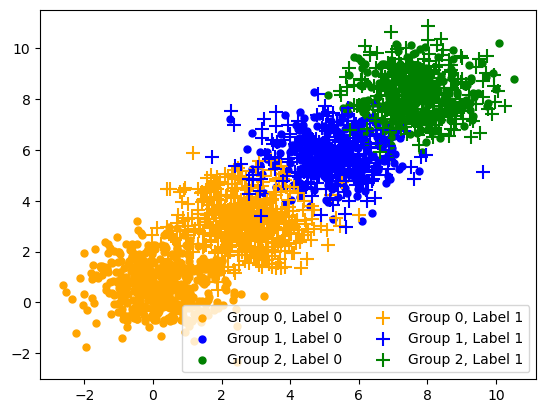

In [184]:
#Create the synthetic dataset

total=2000
X, y, groups, mu, sig = getSyntheticDataset(total)

import itertools
colors = ["orange", "blue", "green", "gray"]
markers = [".", "+"]

indices = list(range(total))
random.shuffle(indices)
# indices = indices[:500]

for label, group in itertools.product(np.unique(y), np.unique(groups)):
    x1 = [X[i][0] for i in indices if y[i]==label and groups[i]==group]
    x2 = [X[i][1] for i in indices if y[i]==label and groups[i]==group]
    
    leg = "Group " + str(group) + ", Label " + str(label)
    plt.scatter(x1, x2, c=colors[group], marker=markers[label], label=leg, s=100)
plt.legend(ncol=2)

- AI System: Orange
- Expert 1: Blue (some distribution)
- Expert 2: Green (some distribution)

In [185]:
X = torch.tensor(X)
y = torch.tensor(y)

In [186]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=456)

In [187]:
# Expert 1
exp_1 = DecisionTreeClassifier().fit(X[1000:1500], y[1000:1500])

# Expert 2
exp_2 = DecisionTreeClassifier().fit(X[1500:2000], y[1500:2000])

trained on their respective clusters

In [188]:
def expert1(inputs):
    return exp_1.predict(inputs)

def expert2(inputs):
    return exp_2.predict(inputs)

In [189]:
d = 2
experts = [expert1, expert2]
k = len(experts)
m = Linear_net_rej_id(d,2,k) # 2 inputs
alpha = 0

run_classifier_rej_id(m, experts, X_train, y_train, alpha, k)


# keep track of what in/correct instances are deferred to each expert by index and inputs
exp_index = [[] for _ in range(k)]

exp1_index, exp2_index = test_classifier_rej_id(m, experts, X_test, y_test, k, exp_index)

system accuracy 55.5
total points: 400

Expert 1 defer count: 90
Expert 1 defer percent: 22.5
Expert 1 correct predictions: 87
Expert 1 accuracy: 96.6664518523292

Expert 2 defer count: 116
Expert 2 defer percent: 29.0
Expert 2 correct predictions: 103
Expert 2 accuracy: 88.79295035698213

Not deferred to any expert count: 194
Not deferred percent: 48.5
Model correct predictions: 32
Model accuracy: 16.494836858331517


Overall expert count: 206
Overall expert defer percent: 51.5
Overall expert correct predictions: 190
Overall expert accuracy: 92.23296493545391


/var/folders/rn/y27_vshj5d549src5ptd24d00000gq/T/ipykernel_44265/1724422467.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(data_x)
/var/folders/rn/y27_vshj5d549src5ptd24d00000gq/T/ipykernel_44265/1724422467.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(data_y)
/var/folders/rn/y27_vshj5d549src5ptd24d00000gq/T/ipykernel_44265/2767994237.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(data_x)
/var/folders/rn/y27_vshj5d549src5ptd24d00000gq/T/ipykernel_44265/27

- overall system accuracy okay, experts deferred on half of instances, experts perform very well but AI performs poor

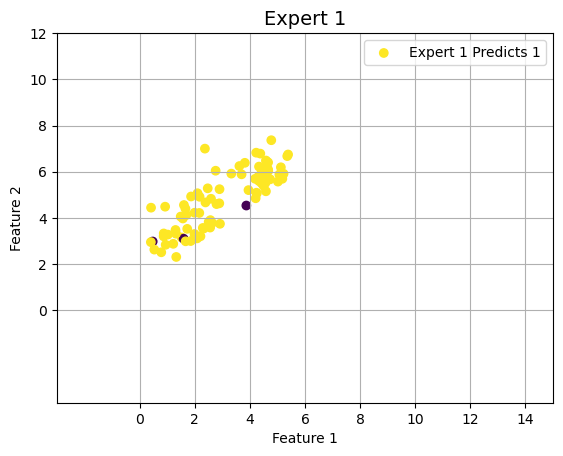

In [190]:
plt.title('Expert 1', fontsize=14)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.xticks(())
plt.yticks(())

plt.xticks(np.arange(0, 16, 2))
plt.yticks(np.arange(0, 16, 2))

plt.xlim(-3, 15)
plt.ylim(-4, 12)

plt.scatter(X_test[exp1_index, 0], X_test[exp1_index, 1], c=(torch.tensor(expert1(X_test[exp1_index])) == y_test[exp1_index])*1, label = 'Expert 1 Predicts 1')
plt.legend()
plt.grid(True)
plt.show()

Instances from expert 1 cluster (blue)

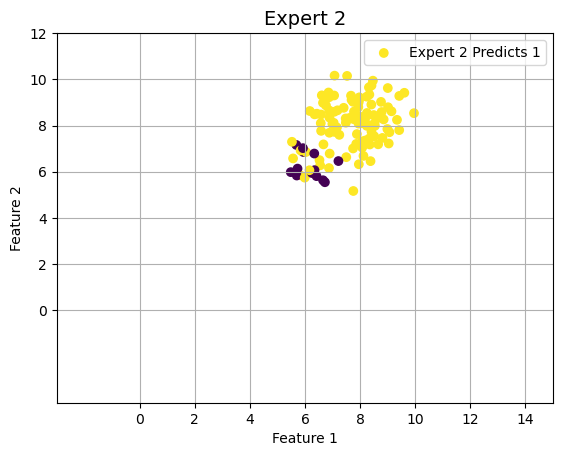

In [191]:
plt.title('Expert 2', fontsize=14)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.xticks(())
plt.yticks(())

plt.xticks(np.arange(0, 16, 2))
plt.yticks(np.arange(0, 16, 2))

plt.xlim(-3, 15)
plt.ylim(-4, 12)

plt.scatter(X_test[exp2_index, 0], X_test[exp2_index, 1], c=(torch.tensor(expert2(X_test[exp2_index])) == y_test[exp2_index])*1, label = 'Expert 2 Predicts 1')
plt.legend()
plt.grid(True)
plt.show()

Instances mostly from expert 2 cluster (green)

In [199]:
m = Linear_net_rej(d,2) # 2 inputs
alpha = 0
p = 0.5

run_classifier_rej(m, experts, X_train, y_train, alpha, p, k)

# keep track of what in/correct instances are deferred to each expert by index and inputs
exp_index = [[] for _ in range(k)]

exp1_index, exp2_index = test_classifier_rej(m, experts, X_test, y_test, p, k, exp_index)

system accuracy 52.75
total points: 400

Expert 1 defer count: 30
Expert 1 defer percent: 7.5
Expert 1 correct predictions: 28
Expert 1 accuracy: 93.33271111525923

Expert 2 defer count: 22
Expert 2 defer percent: 5.5
Expert 2 correct predictions: 12
Expert 2 accuracy: 54.5449586821938

Not deferred to any expert count: 348
Not deferred percent: 87.0
Model correct predictions: 171
Model accuracy: 49.137916914391695


Overall expert count: 52
Overall expert defer percent: 13.0
Overall expert correct predictions: 40
Overall expert accuracy: 76.92292899436731


/var/folders/rn/y27_vshj5d549src5ptd24d00000gq/T/ipykernel_44265/140730015.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(data_x)
/var/folders/rn/y27_vshj5d549src5ptd24d00000gq/T/ipykernel_44265/140730015.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(data_y)
/var/folders/rn/y27_vshj5d549src5ptd24d00000gq/T/ipykernel_44265/540809667.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(data_x)
/var/folders/rn/y27_vshj5d549src5ptd24d00000gq/T/ipykernel_44265/54080

Overall system performs lower, experts deferred not as often, experts performs lower, AI performs better

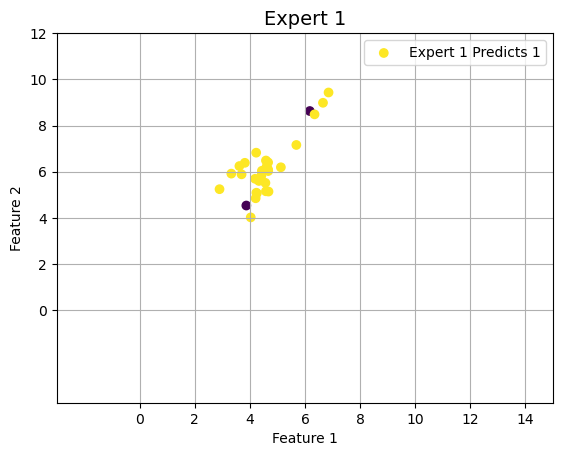

In [200]:
plt.title('Expert 1', fontsize=14)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.xticks(())
plt.yticks(())

plt.xticks(np.arange(0, 16, 2))
plt.yticks(np.arange(0, 16, 2))

plt.xlim(-3, 15)
plt.ylim(-4, 12)

plt.scatter(X_test[exp1_index, 0], X_test[exp1_index, 1], c=(torch.tensor(expert1(X_test[exp1_index])) == y_test[exp1_index])*1, label = 'Expert 1 Predicts 1')
plt.legend()
plt.grid(True)
plt.show()

Instances deferred to experts' clusters (blue and green)

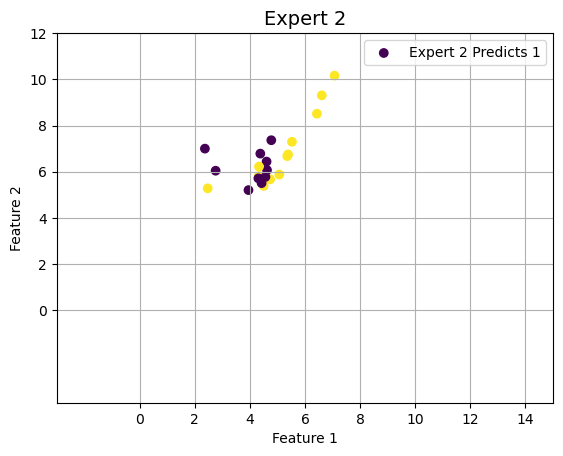

In [201]:
plt.title('Expert 2', fontsize=14)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.xticks(())
plt.yticks(())

plt.xticks(np.arange(0, 16, 2))
plt.yticks(np.arange(0, 16, 2))

plt.xlim(-3, 15)
plt.ylim(-4, 12)

plt.scatter(X_test[exp2_index, 0], X_test[exp2_index, 1], c=(torch.tensor(expert2(X_test[exp2_index])) == y_test[exp2_index])*1, label = 'Expert 2 Predicts 1')
plt.legend()
plt.grid(True)
plt.show()

Instances defered to experts' clusters (blue and green)

# Extend Keswani data
- experts are drawn from different distributions and have varying subsets they are trained on
- evaluate difference in deferment trends from standard and optimal approaches

In [170]:
def getSyntheticDataset_maj_min(total=1000):
    X, y, groups = [], [], []
    group_frac = 0.5

    N1 = 2000
    d = 2

    mu = np.array([random.random() for _ in range(d)])
    sig = [[0 for _ in range(d)] for _ in range(d)]
    for i in (range(d)):
        sig[i][i] = random.random() # 2D diagonal matrix with diagonal entries sampled from Unif[0,1]

    N2 = 500
    X = X + list(np.random.multivariate_normal([0,0], [[1, 0], [0, 1]], 500)) # 500, majority, y = 0,1
    for _ in range(N2):
        groups.append(1)

    for _ in range(N2):
        label = flip(0.5)
        y.append(label)

    N3 = 500
    X = X + list(np.random.multivariate_normal([2,2], [[1, 0], [0, 1]], 500)) # 500, majority, y = 0,1
    for _ in range(N3):
        groups.append(2)

    for _ in range(N3):
        label = flip(0.5)
        y.append(label)

    N4 = 500
    X = X + list(np.random.multivariate_normal(mu+6, sig, N2)) # 250, orange y = 0
    X = X + list(np.random.multivariate_normal(mu+8, sig, N2)) # 250, orange y = 1
    for _ in range(N4):
        groups.append(0)
        y.append(0)

    for _ in range(N4):
        groups.append(0)
        y.append(1)

    return X, y, groups, mu, sig

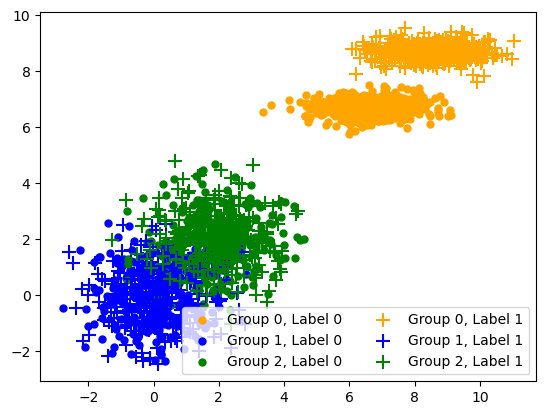

In [171]:
#Create the synthetic dataset

total=2000
X, y, groups, mu, sig = getSyntheticDataset_maj_min(total)

import itertools
colors = ["orange", "blue", "green", "gray"]
markers = [".", "+"]

indices = list(range(total))
random.shuffle(indices)
# indices = indices[:500]

for label, group in itertools.product(np.unique(y), np.unique(groups)):
    x1 = [X[i][0] for i in indices if y[i]==label and groups[i]==group]
    x2 = [X[i][1] for i in indices if y[i]==label and groups[i]==group]
    
    leg = "Group " + str(group) + ", Label " + str(label)
    plt.scatter(x1, x2, c=colors[group], marker=markers[label], label=leg, s=100)
plt.legend(ncol=2)

- Expert 1: Blue N(0,1)
- Expert 2: Green N(2,1)
- AI system: Orange

In [172]:
X = torch.tensor(X)
y = torch.tensor(y)

In [173]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=456)

## whole training and testing the same, vary training for experts when fixed

In [174]:
# Expert 1
exp_1 = DecisionTreeClassifier().fit(X[:450], y[:450])

# Expert 2
exp_2 = DecisionTreeClassifier().fit(X[600:650], y[600:650])

Expert 1 sees 90% while expert 2 sees 10% to represent majority and minority expert based on how much info we know about them

In [175]:
def expert1(inputs):
    return exp_1.predict(inputs)

def expert2(inputs):
    return exp_2.predict(inputs)

In [129]:
def plot_boundary(clf, X, Y):
    h = 0.02
    x_min, x_max = X[:,0].min() - 10*h, X[:,0].max() + 10*h
    y_min, y_max = X[:,1].min() - 10*h, X[:,1].max() + 10*h
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(5,5))
    plt.contourf(xx, yy, Z, alpha=0.25)
    plt.contour(xx, yy, Z, colors='k', linewidths=0.7)
    plt.scatter(X[:,0], X[:,1], c=Y, cmap='jet', edgecolors='k')

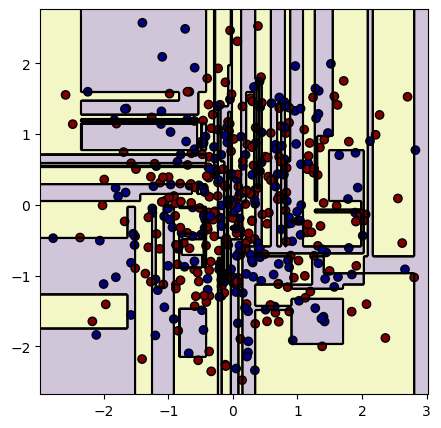

In [176]:
plot_boundary(exp_1, X[:450], y[:450])

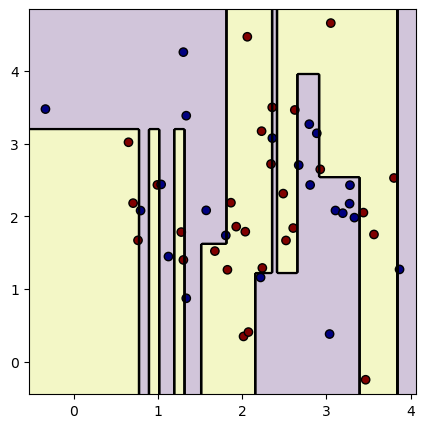

In [177]:
plot_boundary(exp_2, X[600:650], y[600:650])

In [178]:
d = 2
experts = [expert1, expert2]
k = len(experts)
m = Linear_net_rej_id(d,2,k) # 2 inputs
alpha = 0

run_classifier_rej_id(m, experts, X_train, y_train, alpha, k)


# keep track of what in/correct instances are deferred to each expert by index and inputs
exp_index = [[] for _ in range(k)]

exp1_index, exp2_index = test_classifier_rej_id(m, experts, X_test, y_test, k, exp_index)

system accuracy 57.0
total points: 400

Expert 1 defer count: 158
Expert 1 defer percent: 39.5
Expert 1 correct predictions: 99
Expert 1 accuracy: 62.6581485339892

Expert 2 defer count: 117
Expert 2 defer percent: 29.25
Expert 2 correct predictions: 65
Expert 2 accuracy: 55.55546058895626

Not deferred to any expert count: 125
Not deferred percent: 31.25
Model correct predictions: 64
Model accuracy: 51.199959040032766


Overall expert count: 275
Overall expert defer percent: 68.75
Overall expert correct predictions: 164
Overall expert accuracy: 59.63634195042111


/var/folders/rn/y27_vshj5d549src5ptd24d00000gq/T/ipykernel_44265/1724422467.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(data_x)
/var/folders/rn/y27_vshj5d549src5ptd24d00000gq/T/ipykernel_44265/1724422467.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(data_y)
/var/folders/rn/y27_vshj5d549src5ptd24d00000gq/T/ipykernel_44265/2767994237.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(data_x)
/var/folders/rn/y27_vshj5d549src5ptd24d00000gq/T/ipykernel_44265/27

System accuracy not too good, expert deferred on a little over half of instances but accuracy not too good

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


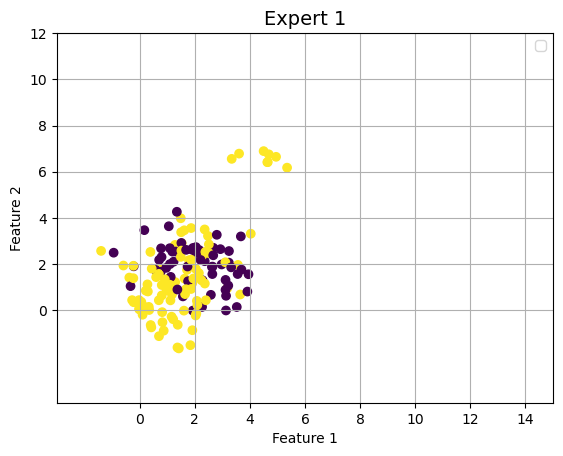

In [179]:
plt.title('Expert 1', fontsize=14)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.xticks(())
plt.yticks(())

plt.xticks(np.arange(0, 16, 2))
plt.yticks(np.arange(0, 16, 2))

plt.xlim(-3, 15)
plt.ylim(-4, 12)

plt.scatter(X_test[exp1_index, 0], X_test[exp1_index, 1], c=(torch.tensor(expert1(X_test[exp1_index])) == y_test[exp1_index])*1)
plt.legend()
plt.grid(True)
plt.show()

Instances from expert 1 cluster (blue)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


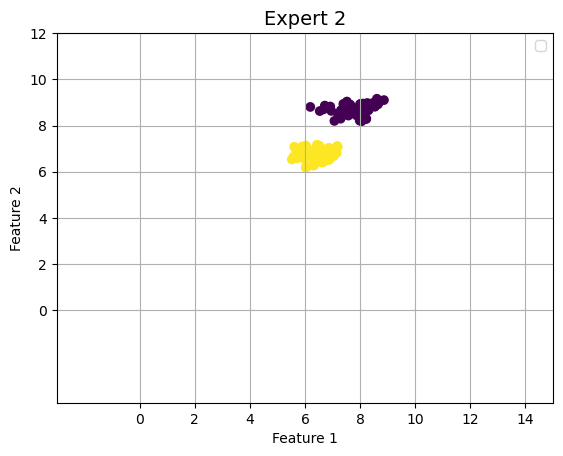

In [180]:
plt.title('Expert 2', fontsize=14)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.xticks(())
plt.yticks(())

plt.xticks(np.arange(0, 16, 2))
plt.yticks(np.arange(0, 16, 2))

plt.xlim(-3, 15)
plt.ylim(-4, 12)

plt.scatter(X_test[exp2_index, 0], X_test[exp2_index, 1], c=(torch.tensor(expert2(X_test[exp2_index])) == y_test[exp2_index])*1)
plt.legend()
plt.grid(True)
plt.show()

Instances outside of expert 2 cluster

In [181]:
m = Linear_net_rej(d,2) # 2 inputs
alpha = 0
p = 0.5

run_classifier_rej(m, experts, X_train, y_train, alpha, p, k)

# keep track of what in/correct instances are deferred to each expert by index and inputs
exp_index = [[] for _ in range(k)]

exp1_index, exp2_index = test_classifier_rej(m, experts, X_test, y_test, p, k, exp_index)

system accuracy 48.0
total points: 400

Expert 1 defer count: 14
Expert 1 defer percent: 3.5
Expert 1 correct predictions: 4
Expert 1 accuracy: 28.571020413994088

Expert 2 defer count: 17
Expert 2 defer percent: 4.25
Expert 2 correct predictions: 10
Expert 2 accuracy: 58.82283737838379

Not deferred to any expert count: 369
Not deferred percent: 92.25
Model correct predictions: 178
Model accuracy: 48.23846931206794


Overall expert count: 31
Overall expert defer percent: 7.75
Overall expert correct predictions: 14
Overall expert accuracy: 45.1611446414689


/var/folders/rn/y27_vshj5d549src5ptd24d00000gq/T/ipykernel_44265/140730015.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(data_x)
/var/folders/rn/y27_vshj5d549src5ptd24d00000gq/T/ipykernel_44265/140730015.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(data_y)
/var/folders/rn/y27_vshj5d549src5ptd24d00000gq/T/ipykernel_44265/540809667.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(data_x)
/var/folders/rn/y27_vshj5d549src5ptd24d00000gq/T/ipykernel_44265/54080

System accuracy lower, expert deferment lower, expert accuracy lower

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


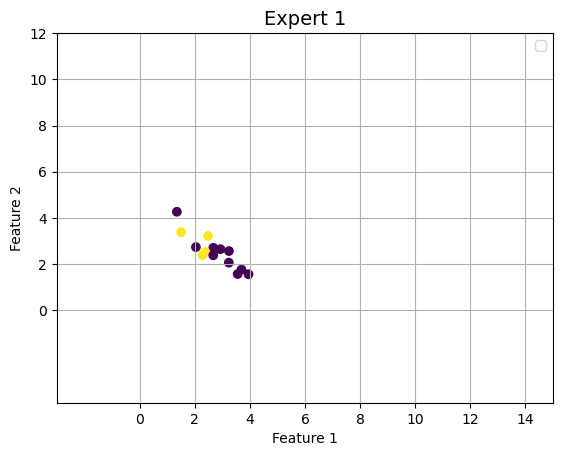

In [182]:
plt.title('Expert 1', fontsize=14)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.xticks(())
plt.yticks(())

plt.xticks(np.arange(0, 16, 2))
plt.yticks(np.arange(0, 16, 2))

plt.xlim(-3, 15)
plt.ylim(-4, 12)

plt.scatter(X_test[exp1_index, 0], X_test[exp1_index, 1], c=(torch.tensor(expert1(X_test[exp1_index])) == y_test[exp1_index])*1)
plt.legend()
plt.grid(True)
plt.show()

Instances from expert 1 cluster (blue)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


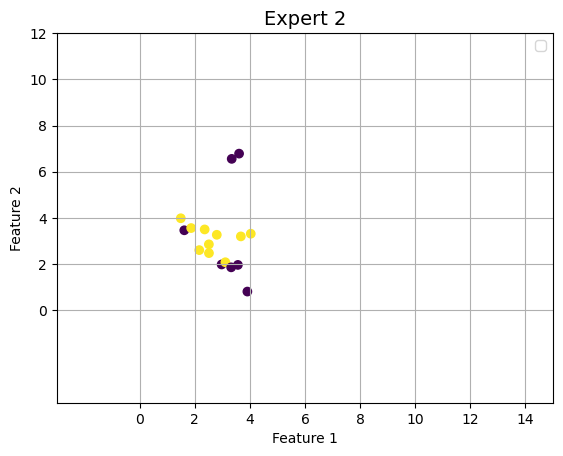

In [183]:
plt.title('Expert 2', fontsize=14)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.xticks(())
plt.yticks(())

plt.xticks(np.arange(0, 16, 2))
plt.yticks(np.arange(0, 16, 2))

plt.xlim(-3, 15)
plt.ylim(-4, 12)

plt.scatter(X_test[exp2_index, 0], X_test[exp2_index, 1], c=(torch.tensor(expert2(X_test[exp2_index])) == y_test[exp2_index])*1)
plt.legend()
plt.grid(True)
plt.show()

Instances from expert 2 cluster (green)

knobs:
- change mean and sd for distributions
- change % of training data for each expert